In [33]:
import os
import random
import pathlib
import time
import struct
import operator


import numpy as np
import pandas as pd
import scipy
import scipy.fft
import phik

from matplotlib import pyplot as plt
import seaborn as sns

import sqlite3
import json

#import torch as torch
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from tqdm.notebook import tqdm

from datasets import load_dataset, load_metric

In [84]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [35]:
PROJECT_FOLDER = os.path.abspath(os.path.join(pathlib.Path().resolve(), os.pardir))

TITANIC_NOTEBOOKS_FOLDER = pathlib.Path().resolve()

TITANIC_RESULTS_FOLDER = os.path.join(PROJECT_FOLDER, 'titanic_results_folder')

if not os.path.isdir(TITANIC_RESULTS_FOLDER):
   os.makedirs(TITANIC_RESULTS_FOLDER)

TITANIC_INITIAL_DATA_PATH = os.path.join(TITANIC_RESULTS_FOLDER, 'titanic_initial_data.csv')
TITANIC_PROCESSED_DATA_PATH = os.path.join(TITANIC_RESULTS_FOLDER, 'titanic_processed_data.csv')

In [36]:
TARGET_COL_NAME = 'survived'


In [ ]:
df = pd.read_csv(TITANIC_PROCESSED_DATA_PATH)

y = df[TARGET_COL_NAME]
X = df.drop(columns=TARGET_COL_NAME)

print(X.isna().sum())
print(y.isna().sum())

sex            0
age            0
sibsp          0
parch          0
fare           0
class          0
who            0
adult_male     0
embark_town    0
alone          0
dtype: int64
0


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
print(f'X_train.shape: {X_train.shape}\n')
print(f'X_test.shape: {X_test.shape}\n')
print(f'y_train.shape: {y_train.shape}\n')
print(f'y_test.shape: {y_test.shape}\n')

X_train.shape: (666, 10)

X_test.shape: (223, 10)

y_train.shape: (666,)

y_test.shape: (223,)



In [70]:
def strat_kfolds_cross_validation(X, y, model_class, model_params, n_splits = 5, metrics_dict=None, threshold=0.5):
    """
    Стратифицированная кросс-валидация с предобработкой данных.

    Parameters:
        X (pd.DataFrame): Фичи.
        y (pd.Series): Целевая переменная.
        model_class (class): Класс модели (например, LogisticRegression).
        model_params (dict): Гиперпараметры модели.
        n_splits (int): Количество фолдов.
        metrics_dict (dict): Словарь метрик вида {name: function}.
        threshold (float): Порог для бинаризации вероятностей.

    Returns:
        pipelines (list): Обученные пайплайны для каждого фолда.
        probabilities (list): Вероятности для каждого фолда.
        scores (dict): Результаты метрик.
    """
    if not metrics_dict:
        metrics_dict = {'accuracy': accuracy_score, 'roc_auc': roc_auc_score}

    skf = StratifiedKFold(n_splits=n_splits)
    
    pipes, val_indexes, probs, true_answers = [], [], [], []
    scores = {key: list() for key in metrics_dict}

    preproccessor = make_column_transformer((StandardScaler(), make_column_selector(dtype_include=np.number)),
                                            (OneHotEncoder(), make_column_selector(dtype_include=object)) )

    for i, (train_index, val_index) in enumerate(skf.split(X, y)):      # skf split возвращает номера строк -> используем iloc     
        X_folds_train = X.iloc[train_index]
        X_folds_val = X.iloc[val_index]

        y_folds_train = y.iloc[train_index]
        y_folds_val = y.iloc[val_index]

        pipe = Pipeline([('column transformer', preproccessor), ('model', model_class(**model_params))])
        pipe.fit(X_folds_train, y_folds_train)
        probas = pipe.predict_proba(X_folds_val)[:, 1]      # т.к. для 2 классов он выдает [p,1-p]

        for name, metric in metrics_dict.items():
            if name in ['roc_auc', 'log_loss']:
                score = metric(y_folds_val, probas)
            else:
                y_pred = (probas >= threshold).astype(int)
                score = metric(y_folds_val, y_pred)
            scores[name].append(score)

        val_indexes.append(X.iloc[val_index].index.values.tolist())
        pipes.append(pipe)
        probs.append(probas)
        true_answers.append(y.iloc[val_index])

    return pipes, val_indexes, probs, true_answers, scores

In [71]:
N_SPLITS = 5

res_pipes, res_val_indexes, res_probs, res_true_answers, res_model_scores = strat_kfolds_cross_validation(X_train, 
                                                                        y_train, 
                                                                        DecisionTreeClassifier, 
                                                                        {}, 
                                                                        n_splits = N_SPLITS,
                                                                        metrics_dict = {'accuracy': accuracy_score,
                                                                        'recall': recall_score,
                                                                        'precision': precision_score,
                                                                        'roc_auc': roc_auc_score})

for name, score in res_model_scores.items():
    print(f'{name}: {np.mean(score)}')

accuracy: 0.8018740882055887
recall: 0.7233469387755103
precision: 0.7448498964803313
roc_auc: 0.7901788729261068


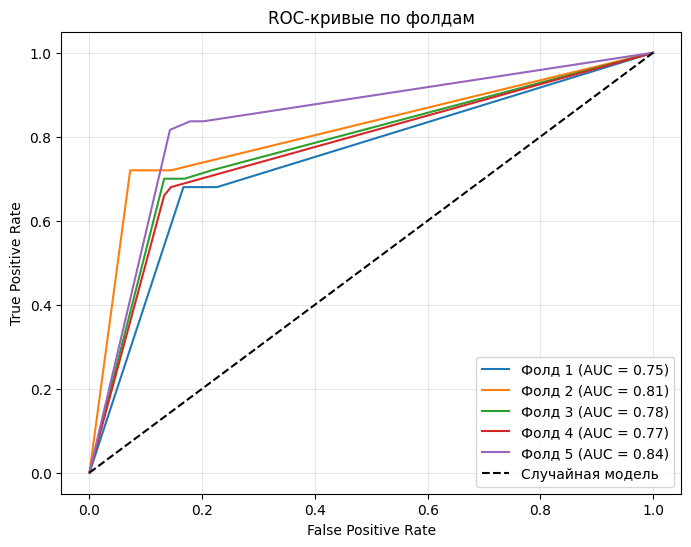

In [72]:
def plot_roc_curves(true_answers, probs):
    """
    Строит ROC-кривые для каждого фолда.
    
    Parameters:
        true_answers (list): Список истинных ответов для каждого фолда.
        probs (list): Список вероятностей для каждого фолда.
        output_file (str): Имя файла для сохранения графика.
    """
    plt.figure(figsize=(8, 6))
    
    for fold_idx, (y_true, y_prob) in enumerate(zip(true_answers, probs)):
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Фолд {fold_idx + 1} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Случайная модель')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривые по фолдам')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_roc_curves(res_true_answers, res_probs)

In [77]:
def strat_kfolds_with_hyperopt(X, y, model_class, param_grid=None, n_splits = 5, metrics_dict=None, threshold=0.5):
    """
    Стратифицированная кросс-валидация с предобработкой данных.

    Parameters:
        X (pd.DataFrame): Фичи.
        y (pd.Series): Целевая переменная.
        model_class (class): Класс модели (например, LogisticRegression).
        model_params (dict): Гиперпараметры модели.
        n_splits (int): Количество фолдов.
        metrics_dict (dict): Словарь метрик вида {name: function}.
        threshold (float): Порог для бинаризации вероятностей.

    Returns:
        pipelines (list): Обученные пайплайны для каждого фолда.
        probabilities (list): Вероятности для каждого фолда.
        scores (dict): Результаты метрик.
    """
    if not metrics_dict:
        metrics_dict = {'accuracy': accuracy_score, 'roc_auc': roc_auc_score}

    if param_grid is None:
        param_grid = {
            'model__max_depth': [3, 5, 7],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        }

    skf = StratifiedKFold(n_splits=n_splits)
    
    best_models, best_params, val_indexes, probs, true_answers = [], [], [], [], []
    scores = {key: list() for key in metrics_dict}

    preproccessor = make_column_transformer((StandardScaler(), make_column_selector(dtype_include=np.number)),
                                            (OneHotEncoder(), make_column_selector(dtype_include=object)) )

    for i, (train_index, val_index) in enumerate(skf.split(X, y)):      # skf split возвращает номера строк -> используем iloc     
        X_folds_train = X.iloc[train_index]
        X_folds_val = X.iloc[val_index]

        y_folds_train = y.iloc[train_index]
        y_folds_val = y.iloc[val_index]

        pipe = Pipeline([('column transformer', preproccessor), ('model', model_class())])
        
        grid_search = GridSearchCV(
            pipe,
            param_grid,
            cv=5,  # Количество слоев кросс-валидации для подбора
            scoring='recall',
            n_jobs=8
        )
        grid_search.fit(X_folds_train, y_folds_train)
        
        best_model = grid_search.best_estimator_
        probas = best_model.predict_proba(X_folds_val)[:, 1]      # т.к. для 2 классов он выдает [p,1-p]

        for name, metric in metrics_dict.items():
            if name in ['roc_auc', 'log_loss']:
                score = metric(y_folds_val, probas)
            else:
                y_pred = (probas >= threshold).astype(int)
                score = metric(y_folds_val, y_pred)
            scores[name].append(score)

        val_indexes.append(X.iloc[val_index].index.values.tolist())
        best_models.append(pipe)
        best_params.append(grid_search.best_params_)
        probs.append(probas)
        true_answers.append(y.iloc[val_index])

    return best_models, best_params, val_indexes, probs, true_answers, scores

In [78]:
param_grid = {
    'model__max_depth': [3, 5, 7],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

res_best_models, res_best_params, res_val_indexes, res_probs, res_true_answers, res_model_scores = strat_kfolds_with_hyperopt(X_train, 
                                                                        y_train, 
                                                                        DecisionTreeClassifier, 
                                                                        param_grid=param_grid, 
                                                                        n_splits = N_SPLITS,
                                                                        metrics_dict = {'accuracy': accuracy_score,
                                                                        'recall': recall_score,
                                                                        'precision': precision_score,
                                                                        'roc_auc': roc_auc_score})

for name, score in res_model_scores.items():
    print(f'{name}: {np.mean(score)}')

accuracy: 0.8213780720457862
recall: 0.7351020408163265
precision: 0.7773703311720173
roc_auc: 0.862953949910429


In [81]:
param_grid = {
    'model__n_estimators': [50, 100, 200],      # Количество деревьев
    'model__max_depth': [3, 5, 7, None],        # Максимальная глубина деревьев
    'model__min_samples_split': [2, 5, 10],     # Минимальное количество образцов для разделения узла
    'model__min_samples_leaf': [1, 2, 4],       # Минимальное количество образцов в листе
    'model__max_features': ['sqrt', 'log2'],    # Количество признаков для выбора при разделении
    'model__class_weight': [None, 'balanced']   # Вес классов для учета несбалансированности
}

res_best_models, res_best_params, res_val_indexes, res_probs, res_true_answers, res_model_scores = strat_kfolds_with_hyperopt(X_train, 
                                                                        y_train, 
                                                                        RandomForestClassifier, 
                                                                        param_grid=param_grid, 
                                                                        n_splits = N_SPLITS,
                                                                        metrics_dict = {'accuracy': accuracy_score,
                                                                        'recall': recall_score,
                                                                        'precision': precision_score,
                                                                        'roc_auc': roc_auc_score})

for name, score in res_model_scores.items():
    print(f'{name}: {np.mean(score)}')

accuracy: 0.8288519806980137
recall: 0.7473469387755103
precision: 0.7840696424113894
roc_auc: 0.8822001533832122


In [86]:
param_grid = {
    'model__n_estimators': [50, 100, 150],        # Количество деревьев
    'model__learning_rate': [0.05, 0.1],          # Скорость обучения
    'model__max_depth': [3, 5],                   # Максимальная глубина
    'model__subsample': [0.8, 1.0],               # Доля выборки
    'model__colsample_bytree': [0.8, 1.0],        # Доля признаков для каждого дерева
    'model__scale_pos_weight': [1, 2]             # Вес положительного класса
}

res_best_models, res_best_params, res_val_indexes, res_probs, res_true_answers, res_model_scores = strat_kfolds_with_hyperopt(X_train, 
                                                                        y_train, 
                                                                        XGBClassifier, 
                                                                        param_grid=param_grid, 
                                                                        n_splits = N_SPLITS,
                                                                        metrics_dict = {'accuracy': accuracy_score,
                                                                        'recall': recall_score,
                                                                        'precision': precision_score,
                                                                        'roc_auc': roc_auc_score})

for name, score in res_model_scores.items():
    print(f'{name}: {np.mean(score)}')

accuracy: 0.834878240377062
recall: 0.7874285714285715
precision: 0.7757365365131322
roc_auc: 0.8841644420246585


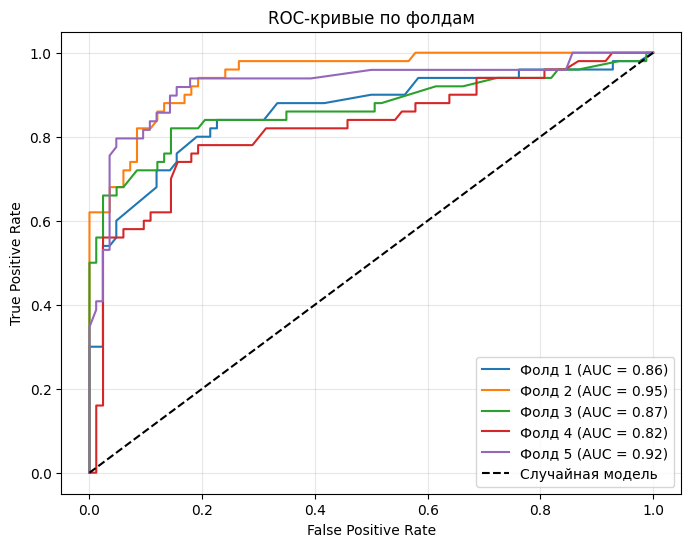

In [87]:
def plot_roc_curves(true_answers, probs):
    """
    Строит ROC-кривые для каждого фолда.
    
    Parameters:
        true_answers (list): Список истинных ответов для каждого фолда.
        probs (list): Список вероятностей для каждого фолда.
        output_file (str): Имя файла для сохранения графика.
    """
    plt.figure(figsize=(8, 6))
    
    for fold_idx, (y_true, y_prob) in enumerate(zip(true_answers, probs)):
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Фолд {fold_idx + 1} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Случайная модель')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривые по фолдам')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_roc_curves(res_true_answers, res_probs)